# MODELO 1 - SEM GENERO E SEM UTILIZADOR: DUPLA OPTIMIZAÇÃO

# :) 

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import warnings

#warnings.filterwarnings("ignore")

plt.rcParams.update({
    "text.usetex": True,              # If you want to use LaTeX fonts in text
    "font.family": "serif",           # IEEE uses Times New Roman-like fonts
    "font.size": 12,                   # General font size for IEEE format
    "axes.labelsize": 12,              # Axis labels font size
    "legend.fontsize": 11,             # Legend font size
    "xtick.labelsize": 11,             # X-axis tick labels font size
    "ytick.labelsize": 11,             # Y-axis tick labels font size
    "figure.figsize": (5, 5*0.8),
    "savefig.dpi": 300,               # DPI for high-quality PNG/JPEG
})

# Load the data

In [2]:
df_train = pd.read_csv("data/data_train.csv")
df_test = pd.read_csv("data/data_test.csv")

In [3]:
with open("data/data_ids.json") as f:
    ids = json.load(f)

max_movieId = max(ids["moviesIDs"].values())
max_userId = max(ids["userIDs"].values())

# Create a matrix of users and movies
base_matrix = np.zeros((max_movieId + 1, max_userId + 1))
base_matrix.shape

(9724, 610)

# Define functions

In [4]:
# Utility matrix and Binary matrix
from scipy.sparse import lil_matrix

def utility_matrix_AND_binary_matrix(dfTrain, zerosMatrix = base_matrix, jsonIds = ids):
    Y = lil_matrix(zerosMatrix.shape)  # Use sparse matrix format
    R = lil_matrix(zerosMatrix.shape)
    for i, row in dfTrain.iterrows():
        original_movieId, original_userId = int(row["movieId"]), int(row["userId"])
        movieId = jsonIds["moviesIDs"][str(original_movieId)]
        userId = jsonIds["userIDs"][str(original_userId)]
        Y[movieId, userId] = row["rating"]
        R[movieId, userId] = 1
    return Y, R

In [5]:
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, Lambda):
    """
    Returns the cost and gradient for the collaborative filtering
    Lambda - regularization parameter
    """
        
    # Unfold the params
    X = params[:num_movies*num_features].reshape(num_movies,num_features)
    Theta = params[num_movies*num_features:].reshape(num_users,num_features)
    
    predictions =  X @ Theta.T
    err = (predictions - Y)
    J = 1/2 * np.sum((err**2) * R)
    
    #compute regularized cost function
    reg_X =  Lambda/2 * np.sum(Theta**2)
    reg_Theta = Lambda/2 *np.sum(X**2)
    reg_J = J + reg_X + reg_Theta
    
    # Compute gradient
    X_grad = err*R @ Theta
    Theta_grad = (err*R).T @ X
    grad = np.append(X_grad.flatten(),Theta_grad.flatten())
    
    # Compute regularized gradient
    reg_X_grad = X_grad + Lambda*X
    reg_Theta_grad = Theta_grad + Lambda*Theta
    reg_grad = np.append(reg_X_grad.flatten(),reg_Theta_grad.flatten())
    
    return J, grad, reg_J, reg_grad

In [6]:
def gradientDescent(initial_parameters,Y,R,num_users,num_movies,num_features,alpha,num_iters,Lambda):
    """
    alpha - learning rate
    Optimize X and Theta
    """
    # unfold the initial parameters (consult function cofiCostFunc)
    X = initial_parameters[:num_movies*num_features].reshape(num_movies,num_features)
    Theta = initial_parameters[num_movies*num_features:].reshape(num_users,num_features)
    
    J_history =[]
    
    for i in range(num_iters):
        #Append into a single vector params X and Theta (see above)
        params = np.append(X.flatten(),Theta.flatten())        
        cost, grad = cofiCostFunc(params, Y, R, num_users, num_movies, num_features, Lambda)[2:]
        
        # unfold grad
        X_grad = grad[:num_movies*num_features].reshape(num_movies,num_features)
        Theta_grad = grad[num_movies*num_features:].reshape(num_users,num_features)
        
        #Update trainable parameters X & Theta applying gradient descent method
        X = X - alpha*X_grad
        
        Theta = Theta - alpha*Theta_grad
        
        J_history.append(cost)
    
    #Append into a single vector paramsFinal the updated X and Theta
    paramsFinal = np.append(X.flatten(),Theta.flatten())
    return paramsFinal , J_history

# Start modelling

- split the df in 8 to do cv

- define num of features to use: 20 because we have 20 diff genres of movies (02 data_vis.ipynb)

In [7]:
# Shuffle the DataFrame randomly and split it into 8 parts
df_shuffled = df_train.sample(frac=1, random_state=42).reset_index(drop=True)
folds = np.array_split(df_shuffled, 8)

# define the number of movies, users and features
num_movies, num_users = base_matrix.shape
num_features = 20

/opt/anaconda3/envs/FAA/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


optimize the hyperparameters of the model using 8cv and minimizing RMSE

In [8]:
"""Lambdas = [0, 5, 6, 7, 8, 10, 13, 15, 20, 25]
alphas = [0.0001, 0.0004, 0.0005, 0.00065, 0.00075, 0.001, 0.0015]
num_iters = 500

combo = 1
results = {}
for Lambda in Lambdas:
    for alpha in alphas:
        print(f"Combination {combo} of {len(Lambdas)*len(alphas)} with ({Lambda}, {alpha}):", end=" ") 
        combo += 1

        avg_RMSE = 0
        for exclude_index in range(8):
            merged_df = pd.concat([part for i, part in enumerate(folds) if i != exclude_index])

            # Create the utility matrix and the binary matrix
            Y, R = utility_matrix_AND_binary_matrix(merged_df)
            Y, R = Y.toarray(), R.toarray()

            # Define the initial parameters
            X = np.random.normal(loc=0, scale=0.3, size=(num_movies, num_features))
            Theta = np.random.normal(loc=0, scale=0.3, size=(num_users, num_features))
            params = np.append(X.flatten(),Theta.flatten())

            # Apply gradient descent
            param, jhist = gradientDescent(params,Y,R,num_users,num_movies,num_features,alpha,num_iters,Lambda)

            # Unfold the final parameters
            X = param[:num_movies*num_features].reshape(num_movies,num_features)
            Theta = param[num_movies*num_features:].reshape(num_users,num_features)

            # Predict all ratings of num_users for num_movies
            p = X @ Theta.T

            # Compute the RMSE
            RMSE = 0
            for i, row in folds[exclude_index].iterrows():
                movieId_matrix = ids["moviesIDs"][str(int(row["movieId"]))]
                userId_matrix = ids["userIDs"][str(int(row["userId"]))]
                RMSE += abs(row["rating"] - p[int(movieId_matrix), int(userId_matrix)])**2
            RMSE = np.sqrt(RMSE/len(folds[exclude_index]))
            print(f"CV{exclude_index+1}: {RMSE:.1f}", end=", ")
            avg_RMSE += RMSE/8
        
        results[(Lambda, alpha)] = avg_RMSE
        print("")"""
"" # dont forget to remove results = results_stored 

''

In [9]:
results_stored = {(0, 0.0001): np.float64(1.4072155396070718),
 (0, 0.0004): np.float64(1.329441099136409),
 (0, 0.0005): np.float64(1.331832787510863),
 (0, 0.00065): np.float64(1.3538502353564172),
 (0, 0.00075): np.float64(1.3670562968234878),
 (0, 0.001): np.float64(1.399231907427166),
 (0, 0.0015): np.float64(1.5442264523301559),
 (5, 0.0001): np.float64(1.3916450159275262),
 (5, 0.0004): np.float64(1.2595971542706506),
 (5, 0.0005): np.float64(1.2615322851054707),
 (5, 0.00065): np.float64(1.2657603187182012),
 (5, 0.00075): np.float64(1.2660834153538214),
 (5, 0.001): np.float64(1.269235919121385),
 (5, 0.0015): np.float64(1.4281701904101156),
 (6, 0.0001): np.float64(1.3880787118397724),
 (6, 0.0004): np.float64(1.258036975590825),
 (6, 0.0005): np.float64(1.2562210608559057),
 (6, 0.00065): np.float64(1.2599197078509734),
 (6, 0.00075): np.float64(1.2651038137438524),
 (6, 0.001): np.float64(1.2720538908635541),
 (6, 0.0015): np.float64(1.4239594315407202),
 (7, 0.0001): np.float64(1.3870968421582952),
 (7, 0.0004): np.float64(1.257085789794418),
 (7, 0.0005): np.float64(1.2587336007461594),
 (7, 0.00065): np.float64(1.2610897726698738),
 (7, 0.00075): np.float64(1.261454195272955),
 (7, 0.001): np.float64(1.2686882792502265),
 (7, 0.0015): np.float64(1.4261456547158486),
 (8, 0.0001): np.float64(1.3875208059964381),
 (8, 0.0004): np.float64(1.2597372777982643),
 (8, 0.0005): np.float64(1.2608664814669375),
 (8, 0.00065): np.float64(1.2610153010253864),
 (8, 0.00075): np.float64(1.2661986155111122),
 (8, 0.001): np.float64(1.268767379532215),
 (8, 0.0015): np.float64(1.427841860737669),
 (10, 0.0001): np.float64(1.3949851967912197),
 (10, 0.0004): np.float64(1.268535044726058),
 (10, 0.0005): np.float64(1.2670007102849818),
 (10, 0.00065): np.float64(1.2689003396161314),
 (10, 0.00075): np.float64(1.2720601240889786),
 (10, 0.001): np.float64(1.272805366635899),
 (10, 0.0015): np.float64(1.430976705513454),
 (13, 0.0001): np.float64(1.409880100149872),
 (13, 0.0004): np.float64(1.287353201723529),
 (13, 0.0005): np.float64(1.2895666959086132),
 (13, 0.00065): np.float64(1.287528675568315),
 (13, 0.00075): np.float64(1.2884323185219257),
 (13, 0.001): np.float64(1.2901560328175044),
 (13, 0.0015): np.float64(1.4377377704540053),
 (15, 0.0001): np.float64(1.4169037535407742),
 (15, 0.0004): np.float64(1.3068190187900375),
 (15, 0.0005): np.float64(1.3055199617280704),
 (15, 0.00065): np.float64(1.3052878260700018),
 (15, 0.00075): np.float64(1.3045831918120192),
 (15, 0.001): np.float64(1.3033551677801687),
 (15, 0.0015): np.float64(1.4692610601649292),
 (20, 0.0001): np.float64(1.4504394250236607),
 (20, 0.0004): np.float64(1.355463913004609),
 (20, 0.0005): np.float64(1.3543914597866222),
 (20, 0.00065): np.float64(1.354246478082104),
 (20, 0.00075): np.float64(1.3534108633821984),
 (20, 0.001): np.float64(1.3523986904932916),
 (20, 0.0015): np.float64(1.4931745110271646),
 (25, 0.0001): np.float64(1.4892201242500134),
 (25, 0.0004): np.float64(1.4100417419616782),
 (25, 0.0005): np.float64(1.4092118984960929),
 (25, 0.00065): np.float64(1.4086409821798012),
 (25, 0.00075): np.float64(1.408302702030173),
 (25, 0.001): np.float64(1.4075217187634002),
 (25, 0.0015): np.float64(1.5297191660022733)}
#results_stored
results = results_stored.copy()

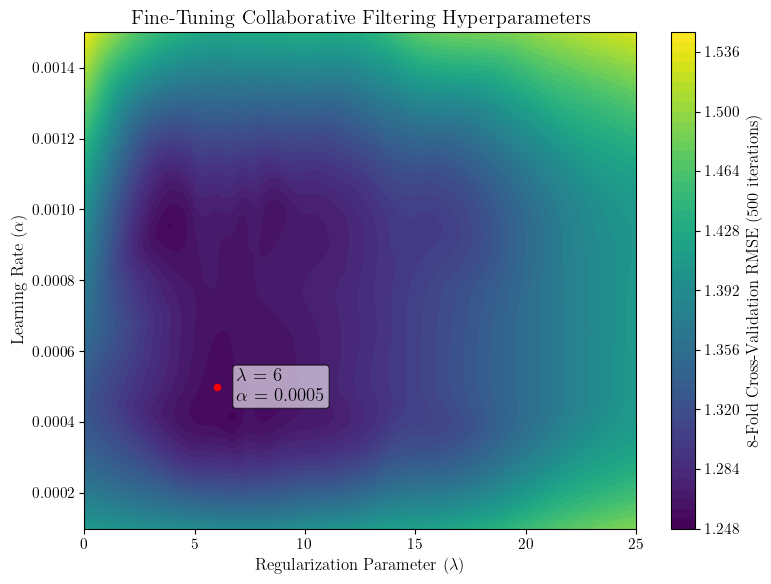

In [10]:
from scipy.interpolate import griddata

# Extract x, y, and z values
points = np.array(list(results.keys()))
x, y = points[:, 0], points[:, 1]
z = np.array(list(results.values()))

# Create a grid for interpolation
xi = np.linspace(min(x), max(x), 100)
yi = np.linspace(min(y), max(y), 100)
xi, yi = np.meshgrid(xi, yi)

# Interpolate z values onto the grid
zi = griddata(points, z, (xi, yi), method='cubic') #nearest, cubic, linear

# Plot the topographic map
plt.figure(figsize=(8, 6))
contour = plt.contourf(xi, yi, zi, levels=50, cmap='viridis')
plt.colorbar(contour, label='8-Fold Cross-Validation RMSE (500 iterations)')
best_lambda, best_alpha = 6, 0.0005
plt.scatter(best_lambda, best_alpha, color='red', s=20)
plt.text(
    best_lambda * 1.15, 
    best_alpha, 
    r"$\lambda$ = " + f"{best_lambda}\n" + r"$\alpha$ = " + str(best_alpha), 
    fontsize=13.5, 
    color='black',
    va = 'center',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2', alpha=0.6)
)
plt.title('Fine-Tuning Collaborative Filtering Hyperparameters')
plt.xlabel(r'Regularization Parameter ($\lambda$)')
plt.ylabel(r'Learning Rate ($\alpha$)')
plt.tight_layout()
#plt.savefig("assets/model01_hyperparametres.png")
plt.show()

In [11]:
# choose the best hyperparameters
best_lambda, best_alpha = 6, 0.0005
print(f"The best hyperparameters are: ({best_lambda}, {best_alpha}) with RMSE: {results_stored[(best_lambda, best_alpha)]:.5f}")

The best hyperparameters are: (6, 0.0005) with RMSE: 1.25622


# Evaluate the optimized model

- predict all ratings

- check convergence

- calculate RMSE, MAE

- ...

- top 10 rated movies

predict the all the ratings

In [12]:
# Create the utility matrix and the binary matrix
Y, R = utility_matrix_AND_binary_matrix(df_train)
Y, R = Y.toarray(), R.toarray()

# Define the initial parameters
X = np.random.normal(loc=0, scale=0.3, size=(num_movies, num_features))
Theta = np.random.normal(loc=0, scale=0.3, size=(num_users, num_features))
params = np.append(X.flatten(),Theta.flatten())

# Apply gradient descent
param, jhist = gradientDescent(params,Y,R,num_users,num_movies,num_features,best_alpha,750,best_lambda)

# Unfold the final parameters
X = param[:num_movies*num_features].reshape(num_movies,num_features)
Theta = param[num_movies*num_features:].reshape(num_users,num_features)

# Predict all ratings of num_users for num_movies
p = X @ Theta.T

cost function convergence

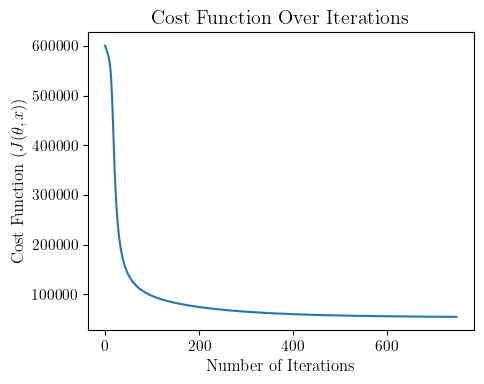

In [13]:
plt.plot(jhist)
plt.title("Cost Function Over Iterations")
plt.xlabel("Number of Iterations")
plt.ylabel(r"Cost Function ($J(\theta , x)$)")
plt.tight_layout()
#plt.savefig("assets/model01_cost_function.png")
plt.show()

rmse

In [14]:
df_to_evaluate = df_train
RMSE = 0
for i, row in df_to_evaluate.iterrows():
    movieId_matrix = ids["moviesIDs"][str(int(row["movieId"]))]
    userId_matrix = ids["userIDs"][str(int(row["userId"]))]
    RMSE += abs(row["rating"] - p[int(movieId_matrix), int(userId_matrix)])**2
RMSE = np.sqrt(RMSE/len(df_to_evaluate))
print(f"RMSE for train set: {RMSE:.5f}")

df_to_evaluate = df_test
RMSE = 0
for i, row in df_to_evaluate.iterrows():
    movieId_matrix = ids["moviesIDs"][str(int(row["movieId"]))]
    userId_matrix = ids["userIDs"][str(int(row["userId"]))]
    RMSE += abs(row["rating"] - p[int(movieId_matrix), int(userId_matrix)])**2
RMSE = np.sqrt(RMSE/len(df_to_evaluate))
print(f"RMSE for test set: {RMSE:.5f}")

RMSE for train set: 0.58766
RMSE for test set: 1.23669


mae

In [15]:
df_to_evaluate = df_train
MAE = 0
for i, row in df_to_evaluate.iterrows():
    movieId_matrix = ids["moviesIDs"][str(int(row["movieId"]))]
    userId_matrix = ids["userIDs"][str(int(row["userId"]))]
    MAE += abs(row["rating"] - p[int(movieId_matrix), int(userId_matrix)])
MAE = MAE/len(df_to_evaluate)
print(f"MAE for train set: {MAE:.5f}")

df_to_evaluate = df_test
MAE = 0
for i, row in df_to_evaluate.iterrows():
    movieId_matrix = ids["moviesIDs"][str(int(row["movieId"]))]
    userId_matrix = ids["userIDs"][str(int(row["userId"]))]
    MAE += abs(row["rating"] - p[int(movieId_matrix), int(userId_matrix)])
MAE = MAE/len(df_to_evaluate)
print(f"MAE for train set: {MAE:.5f}")

MAE for train set: 0.44615
MAE for train set: 0.90375


learning curve ??

In [16]:
"""# Create the utility matrix and the binary matrix
Y, R = utility_matrix_AND_binary_matrix(df_train)
Y, R = Y.toarray(), R.toarray()


# Shuffle the DataFrame randomly and split it into 8 parts
df_shuffled = df_train.sample(frac=1, random_state=42).reset_index(drop=True)
folds = np.array_split(df_shuffled, 8)

dict_RMSE = {}
for fold in range(8):
    merged_df = pd.concat([part for i, part in enumerate(folds) if i != fold])
    Y, R = utility_matrix_AND_binary_matrix(merged_df)
    Y, R = Y.toarray(), R.toarray()

    # Define the initial parameters
    X = np.random.normal(loc=0, scale=0.3, size=(num_movies, num_features))
    Theta = np.random.normal(loc=0, scale=0.3, size=(num_users, num_features))
    params = np.append(X.flatten(),Theta.flatten())
    for iterations in range(0, 751, 150):
    
        # Apply gradient descent
        param, jhist = gradientDescent(params,Y,R,num_users,num_movies,num_features,best_alpha,iterations+1,best_lambda)

        # Unfold the final parameters
        X = param[:num_movies*num_features].reshape(num_movies,num_features)
        Theta = param[num_movies*num_features:].reshape(num_users,num_features)

        # Predict all ratings of num_users for num_movies
        p = X @ Theta.T

        df_to_evaluate = folds[fold]
        RMSE = 0
        for i, row in df_to_evaluate.iterrows():
            movieId_matrix = ids["moviesIDs"][str(int(row["movieId"]))]
            userId_matrix = ids["userIDs"][str(int(row["userId"]))]
            RMSE += abs(row["rating"] - p[int(movieId_matrix), int(userId_matrix)])**2
        RMSE = np.sqrt(RMSE/len(df_to_evaluate))
        dict_RMSE[(fold, iterations, "test")] = RMSE

        df_to_evaluate = merged_df
        RMSE = 0
        for i, row in df_to_evaluate.iterrows():
            movieId_matrix = ids["moviesIDs"][str(int(row["movieId"]))]
            userId_matrix = ids["userIDs"][str(int(row["userId"]))]
            RMSE += abs(row["rating"] - p[int(movieId_matrix), int(userId_matrix)])**2
        RMSE = np.sqrt(RMSE/len(df_to_evaluate))
        dict_RMSE[(fold, iterations, "train")] = RMSE

        print(f"Fold {fold+1} with {iterations+1} in iterations: done")"""
"" # dont forget to remove dict_RMSE = dict_RMSE_stored

''

In [17]:
"""# Create the utility matrix and the binary matrix
Y, R = utility_matrix_AND_binary_matrix(df_train)
Y, R = Y.toarray(), R.toarray()


# Shuffle the DataFrame randomly and split it into 8 parts
df_shuffled = df_train.sample(frac=1, random_state=42).reset_index(drop=True)
folds = np.array_split(df_shuffled, 8)

dict_RMSE = {}
for fold in range(8):
    merged_df = pd.concat([part for i, part in enumerate(folds) if i != fold])

    # Define the initial parameters
    X = np.random.normal(loc=0, scale=0.3, size=(num_movies, num_features))
    Theta = np.random.normal(loc=0, scale=0.3, size=(num_users, num_features))
    params = np.append(X.flatten(),Theta.flatten())
    for train_set_size in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:

        merged_df_sized = merged_df.sample(frac=train_set_size, random_state=42)

        Y, R = utility_matrix_AND_binary_matrix(merged_df_sized)
        Y, R = Y.toarray(), R.toarray()

        
    
        # Apply gradient descent
        param, jhist = gradientDescent(params,Y,R,num_users,num_movies,num_features,best_alpha,750,best_lambda)

        # Unfold the final parameters
        X = param[:num_movies*num_features].reshape(num_movies,num_features)
        Theta = param[num_movies*num_features:].reshape(num_users,num_features)

        # Predict all ratings of num_users for num_movies
        p = X @ Theta.T

        df_to_evaluate = folds[fold]
        RMSE = 0
        for i, row in df_to_evaluate.iterrows():
            movieId_matrix = ids["moviesIDs"][str(int(row["movieId"]))]
            userId_matrix = ids["userIDs"][str(int(row["userId"]))]
            RMSE += abs(row["rating"] - p[int(movieId_matrix), int(userId_matrix)])**2
        RMSE = np.sqrt(RMSE/len(df_to_evaluate))
        dict_RMSE[(fold, train_set_size, "test")] = RMSE

        df_to_evaluate = merged_df
        RMSE = 0
        for i, row in df_to_evaluate.iterrows():
            movieId_matrix = ids["moviesIDs"][str(int(row["movieId"]))]
            userId_matrix = ids["userIDs"][str(int(row["userId"]))]
            RMSE += abs(row["rating"] - p[int(movieId_matrix), int(userId_matrix)])**2
        RMSE = np.sqrt(RMSE/len(df_to_evaluate))
        dict_RMSE[(fold, train_set_size, "train")] = RMSE

        print(f"Fold {fold+1} with {train_set_size} in train_set_size: done")"""
""

''

In [18]:
dict_RMSE_stored_TrainSIZE = {(0, 0.1, 'test'): 2.773463391393424,
 (0, 0.1, 'train'): 2.677702888923426,
 (0, 0.2, 'test'): 2.045077710180417,
 (0, 0.2, 'train'): 1.898628912684764,
 (0, 0.3, 'test'): 1.7680407400358884,
 (0, 0.3, 'train'): 1.5551110181016075,
 (0, 0.4, 'test'): 1.6075772742093992,
 (0, 0.4, 'train'): 1.3319171672643173,
 (0, 0.5, 'test'): 1.5045805475107379,
 (0, 0.5, 'train'): 1.1709411249570845,
 (0, 0.6, 'test'): 1.435154218563347,
 (0, 0.6, 'train'): 1.0425708085351237,
 (0, 0.7, 'test'): 1.373432900116361,
 (0, 0.7, 'train'): 0.9237437770061945,
 (0, 0.8, 'test'): 1.3314757083429805,
 (0, 0.8, 'train'): 0.8122425165148609,
 (0, 0.9, 'test'): 1.2944032306787363,
 (0, 0.9, 'train'): 0.705366688476143,
 (0, 1.0, 'test'): 1.2541730130501525,
 (0, 1.0, 'train'): 0.5971952137345173,
 (1, 0.1, 'test'): 2.8820950327897754,
 (1, 0.1, 'train'): 2.780609707863023,
 (1, 0.2, 'test'): 2.0930026957593633,
 (1, 0.2, 'train'): 1.9329463814144607,
 (1, 0.3, 'test'): 1.769089092355633,
 (1, 0.3, 'train'): 1.5635886178679896,
 (1, 0.4, 'test'): 1.5992153459390226,
 (1, 0.4, 'train'): 1.3377871963309986,
 (1, 0.5, 'test'): 1.494207940334407,
 (1, 0.5, 'train'): 1.1787153651947286,
 (1, 0.6, 'test'): 1.4152207735446172,
 (1, 0.6, 'train'): 1.0426988007408984,
 (1, 0.7, 'test'): 1.357033149286446,
 (1, 0.7, 'train'): 0.9198828319128605,
 (1, 0.8, 'test'): 1.3097379963781104,
 (1, 0.8, 'train'): 0.8120724550109534,
 (1, 0.9, 'test'): 1.2723570926582004,
 (1, 0.9, 'train'): 0.7020008776446228,
 (1, 1.0, 'test'): 1.2461749474666997,
 (1, 1.0, 'train'): 0.5953874102053499,
 (2, 0.1, 'test'): 2.7776873129323185,
 (2, 0.1, 'train'): 2.6711533311153355,
 (2, 0.2, 'test'): 2.049535013602958,
 (2, 0.2, 'train'): 1.892418532324455,
 (2, 0.3, 'test'): 1.7606176234958888,
 (2, 0.3, 'train'): 1.5488606609719298,
 (2, 0.4, 'test'): 1.6057457235497046,
 (2, 0.4, 'train'): 1.330297028042886,
 (2, 0.5, 'test'): 1.5091921848183574,
 (2, 0.5, 'train'): 1.1753139309147749,
 (2, 0.6, 'test'): 1.4354325861056385,
 (2, 0.6, 'train'): 1.0425628716905002,
 (2, 0.7, 'test'): 1.3825262879575702,
 (2, 0.7, 'train'): 0.921755292391535,
 (2, 0.8, 'test'): 1.3408196804130978,
 (2, 0.8, 'train'): 0.8138759342112847,
 (2, 0.9, 'test'): 1.3025884907776333,
 (2, 0.9, 'train'): 0.7045690263044528,
 (2, 1.0, 'test'): 1.2696700525451137,
 (2, 1.0, 'train'): 0.594836397013211,
 (3, 0.1, 'test'): 2.821217170918579,
 (3, 0.1, 'train'): 2.7034511638086376,
 (3, 0.2, 'test'): 2.0610214538636877,
 (3, 0.2, 'train'): 1.8819755328091443,
 (3, 0.3, 'test'): 1.7777420815055596,
 (3, 0.3, 'train'): 1.5434523482576918,
 (3, 0.4, 'test'): 1.6097849676438691,
 (3, 0.4, 'train'): 1.3270259758987082,
 (3, 0.5, 'test'): 1.5057462189285884,
 (3, 0.5, 'train'): 1.1719314348238026,
 (3, 0.6, 'test'): 1.430718375001047,
 (3, 0.6, 'train'): 1.03745020256673,
 (3, 0.7, 'test'): 1.3769738580753286,
 (3, 0.7, 'train'): 0.9148889452727305,
 (3, 0.8, 'test'): 1.3307608685303833,
 (3, 0.8, 'train'): 0.8097364978399672,
 (3, 0.9, 'test'): 1.291872157404178,
 (3, 0.9, 'train'): 0.7025968968783802,
 (3, 1.0, 'test'): 1.2600747161763053,
 (3, 1.0, 'train'): 0.5960966212710681,
 (4, 0.1, 'test'): 2.9173593549039785,
 (4, 0.1, 'train'): 2.7937879036018423,
 (4, 0.2, 'test'): 2.0905631828000235,
 (4, 0.2, 'train'): 1.8995266327234774,
 (4, 0.3, 'test'): 1.7981697959959146,
 (4, 0.3, 'train'): 1.5518434748563879,
 (4, 0.4, 'test'): 1.628747040872785,
 (4, 0.4, 'train'): 1.3345121123248014,
 (4, 0.5, 'test'): 1.5227337305628674,
 (4, 0.5, 'train'): 1.1713789911403631,
 (4, 0.6, 'test'): 1.4521336758602772,
 (4, 0.6, 'train'): 1.0359066647053474,
 (4, 0.7, 'test'): 1.3914832856188726,
 (4, 0.7, 'train'): 0.9150899229595371,
 (4, 0.8, 'test'): 1.345791050948727,
 (4, 0.8, 'train'): 0.8080017542365115,
 (4, 0.9, 'test'): 1.308867128455928,
 (4, 0.9, 'train'): 0.7053433814386691,
 (4, 1.0, 'test'): 1.2769724619300067,
 (4, 1.0, 'train'): 0.5958101224232247,
 (5, 0.1, 'test'): 2.786034278658483,
 (5, 0.1, 'train'): 2.6641881640685026,
 (5, 0.2, 'test'): 2.0584846391425464,
 (5, 0.2, 'train'): 1.8727391650737972,
 (5, 0.3, 'test'): 1.7826475103177797,
 (5, 0.3, 'train'): 1.5405631200071979,
 (5, 0.4, 'test'): 1.6296843961300227,
 (5, 0.4, 'train'): 1.3284412480725927,
 (5, 0.5, 'test'): 1.5301987846794312,
 (5, 0.5, 'train'): 1.1701802356010595,
 (5, 0.6, 'test'): 1.4544879809333848,
 (5, 0.6, 'train'): 1.0366775071257122,
 (5, 0.7, 'test'): 1.3951223563334383,
 (5, 0.7, 'train'): 0.9150931982110921,
 (5, 0.8, 'test'): 1.348814089115429,
 (5, 0.8, 'train'): 0.8079256109527201,
 (5, 0.9, 'test'): 1.309234376880654,
 (5, 0.9, 'train'): 0.7061819893647137,
 (5, 1.0, 'test'): 1.275415579418688,
 (5, 1.0, 'train'): 0.5964790869125207,
 (6, 0.1, 'test'): 2.8270148740215593,
 (6, 0.1, 'train'): 2.7046002375597737,
 (6, 0.2, 'test'): 2.0714064235097447,
 (6, 0.2, 'train'): 1.8871728154328935,
 (6, 0.3, 'test'): 1.7816137237965077,
 (6, 0.3, 'train'): 1.5437881753881175,
 (6, 0.4, 'test'): 1.6187724358545252,
 (6, 0.4, 'train'): 1.3329753062135707,
 (6, 0.5, 'test'): 1.5071669728510868,
 (6, 0.5, 'train'): 1.1683363119062646,
 (6, 0.6, 'test'): 1.4318414946423592,
 (6, 0.6, 'train'): 1.0358835338503574,
 (6, 0.7, 'test'): 1.3760357219751913,
 (6, 0.7, 'train'): 0.9163253933241662,
 (6, 0.8, 'test'): 1.339574172768885,
 (6, 0.8, 'train'): 0.8101019134624223,
 (6, 0.9, 'test'): 1.2971141611629478,
 (6, 0.9, 'train'): 0.705095913981014,
 (6, 1.0, 'test'): 1.271285778431972,
 (6, 1.0, 'train'): 0.595519016872035,
 (7, 0.1, 'test'): 2.815159975152025,
 (7, 0.1, 'train'): 2.6912184234048784,
 (7, 0.2, 'test'): 2.0720933298579554,
 (7, 0.2, 'train'): 1.8832561300492168,
 (7, 0.3, 'test'): 1.78278186010653,
 (7, 0.3, 'train'): 1.545004034903859,
 (7, 0.4, 'test'): 1.632060227128058,
 (7, 0.4, 'train'): 1.338226625485982,
 (7, 0.5, 'test'): 1.5303196972883404,
 (7, 0.5, 'train'): 1.1761736015915498,
 (7, 0.6, 'test'): 1.4466641274462244,
 (7, 0.6, 'train'): 1.0427933680784016,
 (7, 0.7, 'test'): 1.3894442729648777,
 (7, 0.7, 'train'): 0.924014121342054,
 (7, 0.8, 'test'): 1.3463665283725184,
 (7, 0.8, 'train'): 0.8139079807128469,
 (7, 0.9, 'test'): 1.3109158863017933,
 (7, 0.9, 'train'): 0.7078510998306543,
 (7, 1.0, 'test'): 1.2741567068147863,
 (7, 1.0, 'train'): 0.5951922558968368}

In [19]:
dict_RMSE_stored_ITERATIONS = {(0, 750, 'test'): 1.2642876907882,
 (0, 750, 'train'): 0.5951628097939751,
 (1, 750, 'test'): 1.2423532504849735,
 (1, 750, 'train'): 0.5950373349067355,
 (2, 750, 'test'): 1.2623599051874526,
 (2, 750, 'train'): 0.594606045400063,
 (3, 750, 'test'): 1.2694832556873372,
 (3, 750, 'train'): 0.5962717689596361,
 (4, 750, 'test'): 1.2795213003833137,
 (4, 750, 'train'): 0.5951471638159384,
 (5, 750, 'test'): 1.2813730406375818,
 (5, 750, 'train'): 0.5933251729937857,
 (6, 750, 'test'): 1.2744751156343765,
 (6, 750, 'train'): 0.5948662193310665,
 (7, 750, 'test'): 1.2768981886439041,
 (7, 750, 'train'): 0.5921820144744521,
 (0, 0, 'test'): 3.6595371305243094,
 (0, 0, 'train'): 3.669628064844127,
 (0, 150, 'test'): 1.3163167031870568,
 (0, 150, 'train'): 0.8543721283375342,
 (0, 300, 'test'): 1.2549278652082432,
 (0, 300, 'train'): 0.6948578879553721,
 (0, 450, 'test'): 1.248491809946915,
 (0, 450, 'train'): 0.6383390219300569,
 (0, 600, 'test'): 1.2509140052039063,
 (0, 600, 'train'): 0.6104726181471793,
 (1, 0, 'test'): 3.6665996965932957,
 (1, 0, 'train'): 3.668880058020277,
 (1, 150, 'test'): 1.3024741020318151,
 (1, 150, 'train'): 0.8635160026647104,
 (1, 300, 'test'): 1.2432530783880869,
 (1, 300, 'train'): 0.7007862080410194,
 (1, 450, 'test'): 1.2392130914243482,
 (1, 450, 'train'): 0.6401996477750417,
 (1, 600, 'test'): 1.2428015216801664,
 (1, 600, 'train'): 0.6111824703894887,
 (2, 0, 'test'): 3.675929471502242,
 (2, 0, 'train'): 3.665484347719478,
 (2, 150, 'test'): 1.324941014382996,
 (2, 150, 'train'): 0.8594098924234441,
 (2, 300, 'test'): 1.2642128927116292,
 (2, 300, 'train'): 0.6991734349270359,
 (2, 450, 'test'): 1.258277685618568,
 (2, 450, 'train'): 0.6401613965174476,
 (2, 600, 'test'): 1.2609635738622371,
 (2, 600, 'train'): 0.6107655964614846,
 (3, 0, 'test'): 3.691123354225339,
 (3, 0, 'train'): 3.665877998837574,
 (3, 150, 'test'): 1.3265885991067494,
 (3, 150, 'train'): 0.8547588053997949,
 (3, 300, 'test'): 1.2632125013472246,
 (3, 300, 'train'): 0.6962472596992763,
 (3, 450, 'test'): 1.2572025136055485,
 (3, 450, 'train'): 0.6384251286227565,
 (3, 600, 'test'): 1.259761828406944,
 (3, 600, 'train'): 0.6108260276646544,
 (4, 0, 'test'): 3.67408003795559,
 (4, 0, 'train'): 3.6687712447545535,
 (4, 150, 'test'): 1.3365762201585945,
 (4, 150, 'train'): 0.8574629751676249,
 (4, 300, 'test'): 1.2764243678706129,
 (4, 300, 'train'): 0.6968995947334903,
 (4, 450, 'test'): 1.2713579123369816,
 (4, 450, 'train'): 0.6398080935235373,
 (4, 600, 'test'): 1.2740590012731956,
 (4, 600, 'train'): 0.612592460730343,
 (5, 0, 'test'): 3.6825659110416744,
 (5, 0, 'train'): 3.6699942599905757,
 (5, 150, 'test'): 1.3567370527348397,
 (5, 150, 'train'): 0.8579566133878058,
 (5, 300, 'test'): 1.2853403332525188,
 (5, 300, 'train'): 0.6949855341039958,
 (5, 450, 'test'): 1.2736798186359655,
 (5, 450, 'train'): 0.6360418153989097,
 (5, 600, 'test'): 1.2722242888337663,
 (5, 600, 'train'): 0.6085587518974521,
 (6, 0, 'test'): 3.680253616073299,
 (6, 0, 'train'): 3.664684237416986,
 (6, 150, 'test'): 1.3449367123867297,
 (6, 150, 'train'): 0.8556293466177326,
 (6, 300, 'test'): 1.279113248095734,
 (6, 300, 'train'): 0.695744431440632,
 (6, 450, 'test'): 1.2683046955432788,
 (6, 450, 'train'): 0.6381998106960558,
 (6, 600, 'test'): 1.2671661386352442,
 (6, 600, 'train'): 0.6101919556861609,
 (7, 0, 'test'): 3.677704371802784,
 (7, 0, 'train'): 3.668550064010245,
 (7, 150, 'test'): 1.3371870229351663,
 (7, 150, 'train'): 0.8529899490905922,
 (7, 300, 'test'): 1.2716470036422651,
 (7, 300, 'train'): 0.6972996117734637,
 (7, 450, 'test'): 1.2632379344979863,
 (7, 450, 'train'): 0.6390273778424121,
 (7, 600, 'test'): 1.2645401486733858,
 (7, 600, 'train'): 0.6108399134330379}

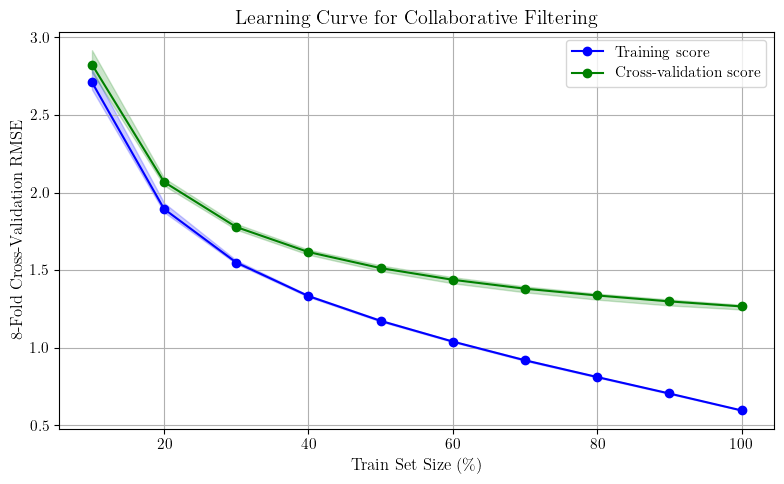

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

data = dict_RMSE_stored_ITERATIONS
data = dict_RMSE_stored_TrainSIZE


def plot_learning_curve(dataset):
    # Step 1: Group by j
    grouped_data = defaultdict(list)
    for (i, j, set), k in data.items():
        if set == dataset and j != 0:
            grouped_data[j].append(k)

    # Step 2: Calculate statistics
    mean_accuracy = []
    std_accuracy = []
    min_a = []
    max_a = []
    iterations = sorted(grouped_data.keys())  # Ensure ordered by j

    for j in iterations:
        values = grouped_data[j]
        mean_accuracy.append(np.mean(values))
        std_accuracy.append(np.std(values))
        min_a.append(np.min(values))
        max_a.append(np.max(values))

    # Step 3: Plot the curve with shaded area
    mean_accuracy = np.array(mean_accuracy)
    std_accuracy = np.array(std_accuracy)

    if dataset == "train":
        plt.plot(np.array(iterations)*100, mean_accuracy, "-o", label="Training score", color="blue")
        plt.fill_between(
            np.array(iterations)*100, 
            min_a, #mean_accuracy - std_accuracy, 
            max_a, #mean_accuracy + std_accuracy, 
            color="blue", alpha=0.2
        )
    else:
        plt.plot(np.array(iterations)*100, mean_accuracy, "-o", label="Cross-validation score", color="green")
        plt.fill_between(
            np.array(iterations)*100, 
            min_a, #mean_accuracy - std_accuracy, 
            max_a, #mean_accuracy + std_accuracy, 
            color="green", alpha=0.2
        )

plt.figure(figsize=(8, 5))
plot_learning_curve("train")
plot_learning_curve("test")

# Step 4: Add labels and legend
plt.xlabel(r"Train Set Size (\%)")
plt.ylabel("8-Fold Cross-Validation RMSE")
plt.title("Learning Curve for Collaborative Filtering")
plt.legend()
plt.grid()
plt.tight_layout()
#plt.savefig("assets/model01_learning_curve.png")
plt.show()


top 10 rated movies (predicted)

nota: como temos muitos missing values, acho q nao ha problema em incluir os dados de treino

In [26]:
movies_avg_ratings = np.mean(p, axis=1)

sorted_indices = np.argsort(movies_avg_ratings)[::-1]
top_10_indices = sorted_indices[:10]

print("Top 10 matrix rows:", top_10_indices)
print("Top 10 avg. ratings:", np.round(movies_avg_ratings[top_10_indices], 2))

moviesId = []
for movie in top_10_indices:
    key = next(k for k, v in ids["moviesIDs"].items() if v == movie)
    moviesId.append(int(key))
movies_names = pd.read_csv("data/movies.csv")
print("\nTop 10 movies:")
for movieId in moviesId:
    print(f'{movieId}: {movies_names[movies_names["movieId"] == movieId]["title"].values[0]}')

Top 10 matrix rows: [ 277  257  314  461  510   46  899 1938 2224  224]
Top 10 avg. ratings: [4.36 4.12 4.1  4.08 4.07 4.06 4.03 4.02 4.01 3.99]

Top 10 movies:
318: Shawshank Redemption, The (1994)
296: Pulp Fiction (1994)
356: Forrest Gump (1994)
527: Schindler's List (1993)
593: Silence of the Lambs, The (1991)
50: Usual Suspects, The (1995)
1198: Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
2571: Matrix, The (1999)
2959: Fight Club (1999)
260: Star Wars: Episode IV - A New Hope (1977)


# saving the model

In [33]:
dicio = {"model01": {"x": X.tolist(), "theta": Theta.tolist(), "lambda": best_lambda, "alpha": best_alpha, "iterations": 750}}

import json
with open("models.json", "w") as file:
    json.dump(dicio, file, indent=4)

In [43]:
"""import numpy as np
import json

# Load the data from the JSON file
with open("models.json", "r") as file:
    dicio_loaded = json.load(file)

# Convert the lists back to NumPy arrays
X_loaded = np.array(dicio_loaded["model01"]["x"])
Theta_loaded = np.array(dicio_loaded["model01"]["theta"])
""" # works
""

''